In [1]:
import numpy as np
import pandas as pd
import unyt as u
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

import sys
sys.path.insert(0, "../IPAM2021_ML/utils/")
import utils as ut
import fancyplots as fp
from sklearn import preprocessing
import sklearn.utils as utils

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2022-03-16 14:55:18.738130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 14:55:18.738157: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def run_gpflow_scipy(x_train, y_train, x_test, y_test, x_testnorm, y_testnorm,scaler, kernel,name_model):
    """Fits GP model to the training data
    Parameters
    ----------
    x_train : np.ndarray
        Training inputs
    y_train : np.ndarray
        Training results
    kernel : function
        GP flow kernel function
    Returns
    -------
    model : 
        fitted GP flow model
    """
    # Create the model
    model = gpflow.models.GPR(
        data=(x_train[:4000], y_train[:4000]),
        kernel=kernel)

    # Print initial values
    print_summary(model, fmt="notebook")

    #Choose the optimizer
    
    # Optimize model with scipy
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(model.training_loss, model.trainable_variables,options=dict(maxiter=100))
    
    # Optimize with Adams
    #adam_learning_rate = 0.11
    #iterations = 50

    #adam_opt_for_gpr = tf.optimizers.Adam(adam_learning_rate)
    #for i in range(iterations):
        #adam_opt_for_gpr.minimize(model.training_loss, var_list=model.trainable_variables)
        #likelihood = model.log_marginal_likelihood()

    # Print the optimized values
    print_summary(model, fmt="notebook")
    
    #predictions 
    
    ypredict, var = model.predict_f(x_testnorm)
    ypredict_rescaled = scaler.inverse_transform(ypredict)
    
    # mean errors 
    m1_inj  = y_test[:,0]
    m2_inj  = y_test[:,1]
    m1_pred = ypredict_rescaled[:,0]
    m2_pred = ypredict_rescaled[:,1]
    q_inj   = m2_inj /m1_inj
    q_pred  = m2_pred/m1_pred
    m1_mean_error = np.mean(np.abs(m1_inj-m1_pred)/m1_inj)
    m2_mean_error = np.mean(np.abs(m2_inj-m2_pred)/m2_inj)
    q_mean_error  = np.mean(np.abs(q_inj - q_pred)/q_inj )
    print('-----------------------------')
    print('Model:', name_model)
    print('m1 mean error:', m1_mean_error)
    print('m2 mean error:', m2_mean_error)
    print('q  mean error:', q_mean_error)

    # Return the model
    return model

def run_gpflow_scipy_noopt_ps(x_train, y_train, x_test, y_test, x_testnorm, y_testnorm,scaler, kernel,name_model):
    """Fits GP model to the training data
    Parameters
    ----------
    x_train : np.ndarray
        Training inputs
    y_train : np.ndarray
        Training results
    kernel : function
        GP flow kernel function
    Returns
    -------
    model : 
        fitted GP flow model
    """
    # Create the model
    model = gpflow.models.GPR(
        data=(x_train[:], y_train[:]),
        kernel=kernel)

    # Print values
    print_summary(model, fmt="notebook")
    
    #predictions 
    
    ypredict, var     = model.predict_f(x_testnorm)
    ypredict_rescaled = scaler.inverse_transform(ypredict)
    
    # mean errors 
    m1_inj  = y_test[:,0]
    m2_inj  = y_test[:,1]
    m1_pred = ypredict_rescaled[:,0]
    m2_pred = ypredict_rescaled[:,1]
    q_inj   = m2_inj /m1_inj
    q_pred  = m2_pred/m1_pred
    m1_mean_error = np.mean(np.abs(m1_inj-m1_pred)/m1_inj)
    m2_mean_error = np.mean(np.abs(m2_inj-m2_pred)/m2_inj)
    q_mean_error  = np.mean(np.abs(q_inj - q_pred)/q_inj )
    print('-----------------------------')
    print('Model:', name_model)
    print('m1 mean error:', m1_mean_error)
    print('m2 mean error:', m2_mean_error)
    print('q  mean error:', q_mean_error)
    
    # Return the model
    return model


## Input parameters

In [3]:
data2use         = 'GSTLAL_2m' # 'NewRealistic' or 'GSTLAL_2m'

# training options
lengthscale      = np.array([1.0,1.0])
variance         = 1.0
kernel_rbf       = gpflow.kernels.SquaredExponential(variance = variance, lengthscales = lengthscale)
mean_function    = None
write_output     = False
remove_some_mass = False
scaler_type      = 'minmax'  # standard, minmax, mixed

2022-03-16 14:55:20.575168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 14:55:20.575213: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 14:55:20.575229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alkyone): /proc/driver/nvidia/version does not exist
2022-03-16 14:55:20.575480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [4]:
if data2use=='NewRealistic':
    features_names   = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z',\
                        'theta', 'q', 'Mc'];
    regr_data_dir    = '../IPAM2021_ML/datasets/NewRealistic/'
    out_data_dir     = '../IPAM2021_ML/datasets/GPR_tf_results/'
    versions         = ['0'] # can be a subset of ['0', '1', '2']
    clabels          = ['0'] # can be a subset of ['0', '1'] 

    # define dictionary for each version considered
    Nv       = len(versions)
    Nc       = len(clabels)
    Nsets    = Nv*Nc

    if Nv*Nc!=Nsets:
        print('+++ Wrong input! +++')

    datasets = {}
    keys     = []
    for i in range(0,Nv):
        version = versions[i]
        for j in range(0,Nc):
            clabel = clabels[j]
            key = 'v'+version+'c'+clabel
            keys.append(key)
            datasets[key]         = lambda:0
            datasets[key].clabel  = clabel
            datasets[key].version = version
            data_paths           = {}
            data_paths['xtrain'] = regr_data_dir+key+'train_x.csv'
            data_paths['ytrain'] = regr_data_dir+key+'train_y.csv'
            data_paths['xtest']  = regr_data_dir+key+'test_x.csv'
            data_paths['ytest']  = regr_data_dir+key+'test_y.csv'
            datasets[key].data_paths = data_paths
            
elif data2use=='GSTLAL_2m':
    features_names    = ['m1', 'm2', 'Mc']
    regr_data_dir     = '../IPAM2021_ML/datasets/GSTLAL_EarlyWarning_Dataset/Dataset/'
    out_data_dir      = '../IPAM2021_ML/datasets/GSTLAL_EarlyWarning_Dataset/Regression_Result/GPR_tf/'
    datasets          = {}
    keys              = ['GSTLAL_2m']
    key               = keys[0]
    datasets[key]     = lambda:0
    data_paths           = {}
    data_paths['xtrain'] = regr_data_dir+'train_recover.csv'
    data_paths['ytrain'] = regr_data_dir+'train_inject.csv'
    data_paths['xtest']  = regr_data_dir+'test_recover.csv'
    data_paths['ytest']  = regr_data_dir+'test_inject.csv'
    datasets[key].data_paths = data_paths

else:
    print("'data2use' can be 'NewRealistic' or 'GSTLAL_2m'")
    sys.exit()

## Train and test the model on the dataset(s)

In [5]:
asterisks = '*'*80
fraction_train   = 0.8
total_entries = 13854

for key in keys:
    print(asterisks, '\nKey: ', key, '\n', asterisks, sep='')
    
    data_paths = datasets[key].data_paths
    
    rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                           remove_some_mass=remove_some_mass,
                           scaler_type=None)
    xtrain = rdl_out['xtrain']
    ytrain = rdl_out['ytrain']
    xtest  = rdl_out['xtest']
    ytest  = rdl_out['ytest']
    labels = rdl_out['labels']

print(np.size(xtrain, axis = 0))
print(np.size(xtest, axis = 0))
#we are going to shuffle the train datasets and then split them into train and test
    
xtrain = utils.shuffle(xtrain,random_state = 5)
ytrain = utils.shuffle(ytrain, random_state = 5)

xtest = utils.shuffle(xtest,random_state = 42)
ytest = utils.shuffle(ytest, random_state = 42)

#train_entries = int(total_entries * fraction_train)

#xtrain = xdata[:train_entries,:]
#xtest = xdata[train_entries:,:]
#ytrain = ydata[:train_entries,:]
#ytest = ydata[train_entries:,:]

#scale data between -1 and 1

scaler       = preprocessing.MinMaxScaler(feature_range=(-1, 1))
xtestminmax  = scaler.fit(xtest)
xtestnorm    = scaler.fit_transform(xtest)
xtrainminmax = scaler.fit(xtrain)
xtrainnorm   = scaler.fit_transform(xtrain)
ytestminmax  = scaler.fit(ytest)
ytestnorm    = scaler.fit_transform(ytest)
ytrainminmax = scaler.fit(ytrain)
ytrainnorm   = scaler.fit_transform(ytrain)

********************************************************************************
Key: GSTLAL_2m
********************************************************************************
13854
5938


In [6]:
%%time
model_rbf_noopt = run_gpflow_scipy_noopt_ps(xtrainnorm[:5000], ytrainnorm[:5000], xtest[:5000], ytest[:5000], xtestnorm[:5000], ytestnorm[:5000], scaler, kernel_rbf, 'RBF')

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1. 1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


-----------------------------
Model: RBF
m1 mean error: 0.022715233234265116
m2 mean error: 0.024567241546156332
q  mean error: 0.04656972986537619
CPU times: user 16 s, sys: 2.56 s, total: 18.5 s
Wall time: 13.7 s


In [7]:
%%time
model_rbf = run_gpflow_scipy(xtrainnorm[:5000], ytrainnorm[:5000], xtest[:5000], ytest[:5000], xtestnorm[:5000], ytestnorm[:5000], scaler, kernel_rbf, 'RBF')


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1. 1.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


2022-03-16 14:55:34.626777: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,7.329050938889623
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[4.07392787 5.27565805]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.019732296972143657


-----------------------------
Model: RBF
m1 mean error: 0.02260129409014629
m2 mean error: 0.024480715130987325
q  mean error: 0.0465049836857782
CPU times: user 51min 30s, sys: 1min 9s, total: 52min 40s
Wall time: 9min 30s


In [8]:
#assign manually the values that you take from above from the optimized model
kernel_rbf.variance.assign(1.2906429301481757)
kernel_rbf.lengthscales.assign([1.80234858, 2.46102759])
optmodel = run_gpflow_scipy_noopt_ps(xtrainnorm[:5000], ytrainnorm[:5000], xtest[:5000], ytest[:5000], xtestnorm[:5000], ytestnorm[:5000], scaler, kernel_rbf, 'RBF')
optmodel.likelihood.variance.assign(0.006613661165534351)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.2906429301481757
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1.80234858 2.46102759]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


-----------------------------
Model: RBF
m1 mean error: 0.022709244259278744
m2 mean error: 0.024581596351621306
q  mean error: 0.046591154710079484


<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-5.015460956682672>

# Errors 

In [11]:
ypredictednorm, var = model_rbf.predict_f(xtestnorm)
ypredicted     = scaler.inverse_transform(ypredictednorm)
abs_rel_err   = np.abs((ytest - ypredicted) /ytest)
rel_err       = (ytest - ypredicted) /ytest
abs_pred_diff = np.abs(ytest - ypredicted)
pred_diff     = ytest - ypredicted

rec_diff      = ytest - xtest
rec_rel_err   = (ytest - xtest)/ytest

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# A bad R2 score does not necessarily mean that our model is wrong.
print("R2 score : %.2f" % r2_score(ytest,ypredicted))
print("Mean squared error: %.7f" % mean_squared_error(ytest,ypredicted))

R2 score : 0.71
Mean squared error: 0.0017581


# Plotting

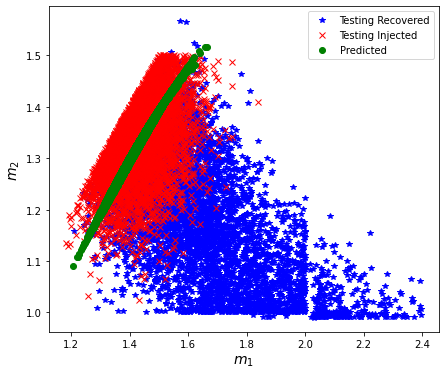

In [20]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(7, 6))
    
    #Recovered
plt.plot(xtest[:,0], xtest[:,1], 'b*', label='Testing Recovered')
          
    #Injected
plt.plot(ytest[:,0], ytest[:,1], 'rx', label='Testing Injected')
    
    #Predicted
plt.plot(ypredicted[:,0], ypredicted[:,1], 'go', label='Predicted')       

plt.xlabel(r'$m_1$', fontsize=14)
plt.ylabel(r'$m_2$', fontsize=14)
plt.legend()

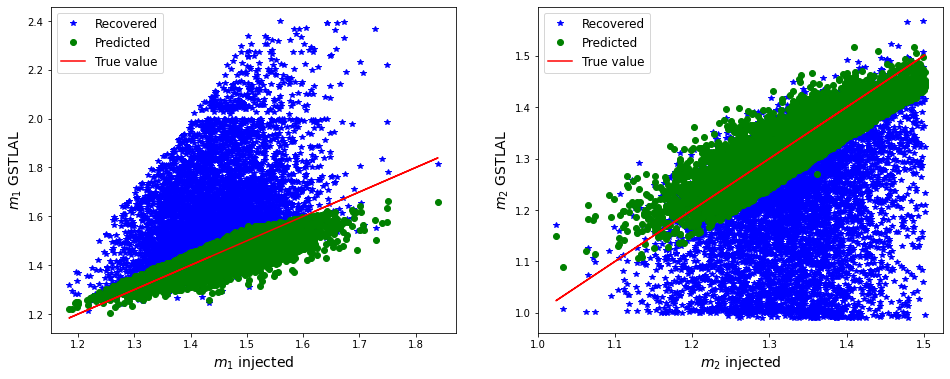

In [21]:
    # Initialize plot
f, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    #Recovered
ax[0].plot(ytest[:,0], xtest[:,0], 'b*', label='Recovered')
ax[1].plot(ytest[:,1], xtest[:,1], 'b*', label='Recovered')
          
    #Predicted
ax[0].plot(ytest[:,0], ypredicted[:,0], 'go', label='Predicted')       
ax[1].plot(ytest[:,1], ypredicted[:,1], 'go', label='Predicted') 
    
    #True values
ax[0].plot(ytest[:,0], ytest[:,0], 'r-', label='True value')     
ax[1].plot(ytest[:,1], ytest[:,1], 'r-', label='True value') 
    
ax[0].set_xlabel(r'$m_1$ injected', fontsize=14)
ax[0].set_ylabel(r'$m_1$ GSTLAL', fontsize=14)
ax[0].legend(fontsize=12)
    
ax[1].set_xlabel(r'$m_2$ injected', fontsize=14)
ax[1].set_ylabel(r'$m_2$ GSTLAL', fontsize=14)
ax[1].legend(fontsize=12)

In [22]:
color_cycle = [
        (53/255.,  74/255.,  93/255.),   # black
        (59/255.,  153/255., 217/255.),  # blue
        (229/255., 126/255., 49/255.),   # orange
        (53/255.,  206/255., 116/255.),  # green
        (230/255., 78/255.,  67/255.),   # red
        (154/255., 91/255.,  179/255.),  # purple
        (240/255., 195/255., 48/255.),   # gold
        '#e377c2',                       # pink
        '#8c564b',                       # brown
        '#7f7f7f',                       # gray
        '#17becf',                       # teal
        '#bcbd22',                       # lime
    ]

The median is:  0.018524740378836092  and the mean is:  0.022667682580015853
The median is:  0.022778617347784618  and the mean is:  0.024505628167851453


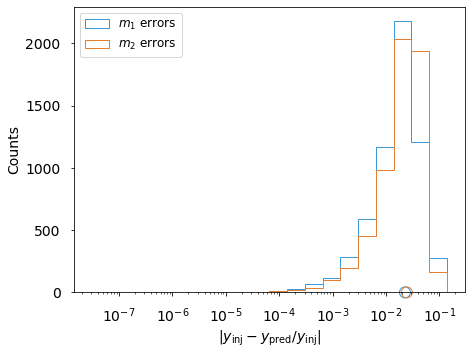

In [23]:
fig, axis = plt.subplots(1, figsize=(7,5.25))

combined_epsilons = [abs_rel_err[:,0], abs_rel_err[:,1]]

hist, bins, _ = axis.hist(combined_epsilons, 20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
axis.clear()

axis.set_xlabel(r'$|y_{\mathrm{inj}}-y_{\mathrm{pred}}/y_{\mathrm{inj}}|$', fontsize=14)
axis.set_ylabel(r'Counts', fontsize=14)
axis.tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$ errors','$m_2$ errors']

color = ['blue', 'orange']
for i in range(len(combined_epsilons)):
    axis.hist(combined_epsilons[i], bins=logbins, histtype=u'step', label=labels[i], color=color_cycle[i+1], ls=styles[i])
    point = axis.scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color_cycle[i+1])
    print('The median is: ',np.median(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)

axis.set_xscale('log')
axis.legend(ncol = 1, loc="upper left", fontsize=12)
plt.show()

The median is:  0.0017820306134954233  and the mean is:  0.007273732908506052
The median is:  0.012157574555305597  and the mean is:  0.0059290853333914045


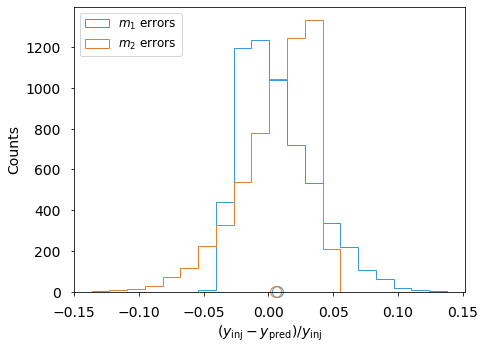

In [24]:
fig, axis = plt.subplots(1, figsize=(7,5.25))

combined_epsilons = [rel_err[:,0], rel_err[:,1]]

hist, bins, _ = axis.hist(combined_epsilons, 20)
axis.clear()

axis.set_xlabel(r'$\left(y_{\mathrm{inj}}-y_{\mathrm{pred}}\right)/y_{\mathrm{inj}}$', fontsize=14)
axis.set_ylabel(r'Counts', fontsize=14)
axis.tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$ errors','$m_2$ errors']

color = ['blue', 'orange']
for i in range(len(combined_epsilons)):
    axis.hist(combined_epsilons[i], bins=bins, histtype=u'step', label=labels[i], color=color_cycle[i+1], ls=styles[i])
    point = axis.scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color_cycle[i+1])
    print('The median is: ',np.median(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)

axis.legend(ncol = 1, loc="upper left", fontsize=12)
plt.show()

The median is:  0.011736705945079638  and the mean is:  0.011736705945079638
The median is:  -0.17806211860895924  and the mean is:  -0.17806211860895924
The median is:  0.01622968654968937  and the mean is:  0.009074598284053827
The median is:  0.11026949999999991  and the mean is:  0.12949669094813068


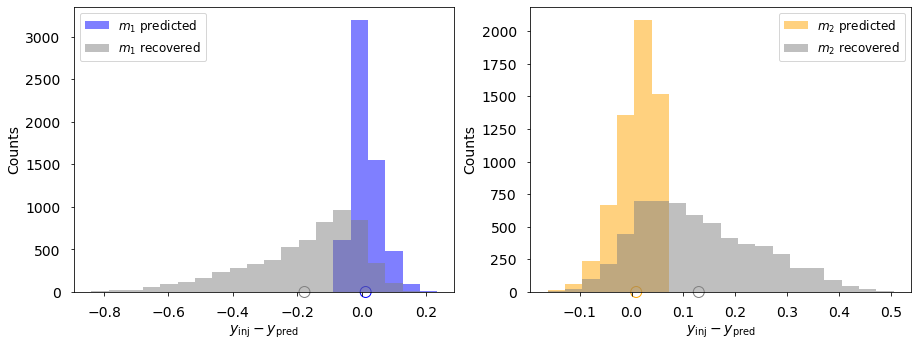

In [25]:
fig, axis = plt.subplots(1,2, figsize=(15,5.25))

combined_epsilons = [pred_diff[:,0], rec_diff[:,0]]

hist, bins, _ = axis[0].hist(combined_epsilons, 20)
axis[0].clear()
axis[0].set_xlabel(r'$y_{\mathrm{inj}}-y_{\mathrm{pred}}$', fontsize=14)
axis[0].set_ylabel(r'Counts', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$ predicted','$m_1$ recovered']

color = ['blue','gray']
for i in range(len(combined_epsilons)):
    axis[0].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[0].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    print('The median is: ',np.mean(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)

axis[0].legend(ncol = 1, loc="upper left", fontsize=12)

###################

combined_epsilons = [pred_diff[:,1], rec_diff[:,1]]

hist, bins, _ = axis[1].hist(combined_epsilons, 20)
axis[1].clear()
axis[1].set_xlabel(r'$y_{\mathrm{inj}}-y_{\mathrm{pred}}$', fontsize=14)
axis[1].set_ylabel(r'Counts', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_2$ predicted','$m_2$ recovered']


color = ['orange','gray']
for i in range(len(combined_epsilons)):
    axis[1].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[1].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    print('The median is: ',np.median(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)
    
axis[1].legend(ncol = 1, loc="upper right", fontsize=12)

plt.show()

The median is:  0.007273732908506052  and the mean is:  0.007273732908506052
The median is:  -0.12361143315003566  and the mean is:  -0.12361143315003566
The median is:  0.012157574555305597  and the mean is:  0.0059290853333914045
The median is:  0.0827874731894478  and the mean is:  0.0959503710052032


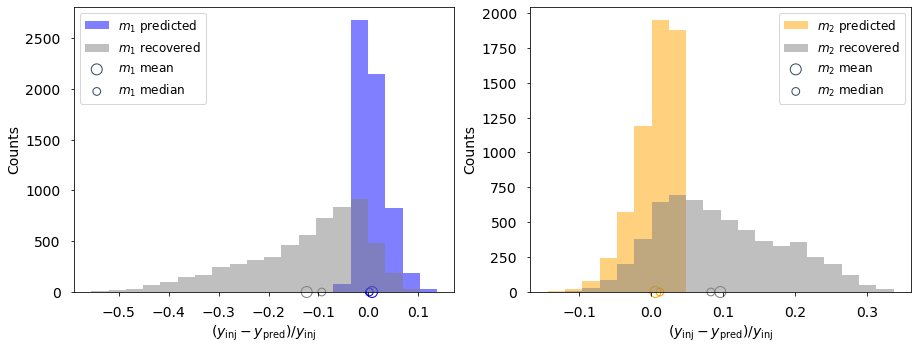

In [26]:
fig, axis = plt.subplots(1,2, figsize=(15,5.25))

combined_epsilons = [rel_err[:,0], rec_rel_err[:,0]]

hist, bins, _ = axis[0].hist(combined_epsilons, 20)
axis[0].clear()
axis[0].set_xlabel(r'$\left(y_{\mathrm{inj}}-y_{\mathrm{pred}}\right)/y_{\mathrm{inj}}$', fontsize=14)
axis[0].set_ylabel(r'Counts', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$ predicted','$m_1$ recovered']

color = ['blue','gray']
for i in range(len(combined_epsilons)):
    axis[0].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[0].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    points = axis[0].scatter(x=np.median(combined_epsilons[i]), y=0, s=60, facecolors='none', edgecolors=color[i])
    print('The median is: ',np.mean(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)
    points.set_clip_on(False)

axis[0].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='$m_1$ mean')
axis[0].scatter(x=[None],y=0, s=60, facecolors='none',color=color_cycle[0], label='$m_1$ median')

axis[0].legend(ncol = 1, loc="upper left", fontsize=12)

###################

combined_epsilons = [rel_err[:,1], rec_rel_err[:,1]]

hist, bins, _ = axis[1].hist(combined_epsilons, 20)
axis[1].clear()
axis[1].set_xlabel(r'$\left(y_{\mathrm{inj}}-y_{\mathrm{pred}}\right)/y_{\mathrm{inj}}$', fontsize=14)
axis[1].set_ylabel(r'Counts', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_2$ predicted','$m_2$ recovered']


color = ['orange','gray']
for i in range(len(combined_epsilons)):
    axis[1].hist(combined_epsilons[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[1].scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    points = axis[1].scatter(x=np.median(combined_epsilons[i]), y=0, s=60, facecolors='none', edgecolors=color[i])
    print('The median is: ',np.median(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)
    points.set_clip_on(False)
    
axis[1].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='$m_2$ mean')
axis[1].scatter(x=[None],y=0, s=60, facecolors='none',color=color_cycle[0], label='$m_2$ median')
    
axis[1].legend(ncol = 1, loc="upper right", fontsize=12)

plt.show()